In [1]:
#include("MAB_module.jl")
include("environment.jl")
include("algorithm_base.jl")
include("eps_greedy.jl")
include("rs.jl")
include("lsx.jl")
#include("meta-bandit.jl")
#include("ucb1tuned.jl")

In [2]:
using Plots
using Statistics
#using Base.Threads

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
mutable struct UCB1 <: Algorithm
    env::Environment
    actionValues::Vector{Float64}
    counts::Vector{Int}             #numbers of selection of each arm.
    total_count::Int
    sum_rewards::Vector             #sum of an earned reward of each arm
    averages::Vector
    variences::Vector
    tuned::Bool
    #constructor
    function UCB1(env::Environment, tuned::Bool)
        return new( env,
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    0,
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    tuned)
    end
end

In [4]:
function init!(algo::UCB1)
    init_algo!(algo)
end
#epsilon greedy
function select_arm(algo::UCB1)
    min, minidx = findmin(algo.actionValues)
    if min == 0
        return minidx
    end
    #return index of maximum value in the action values.
    return greedy(algo)
end

function calc_value(algo::UCB1, selected)
    
    algo.averages[selected] = algo.sum_rewards[selected] / algo.counts[selected]
    if algo.tuned
        algo.variences[selected] = algo.averages[selected] - algo.averages[selected]^2     
        
        for i=1:algo.env.arm_num
            v = (algo.variences[i] < 1/4) ? algo.variences[i] + sqrt((2*log(algo.total_count))/algo.counts[i]) : 1/4
            algo.actionValues[i] =
                algo.averages[i] + sqrt((log(algo.total_count)/algo.counts[i]) * v)
        end
    else
        algo.actionValues[selected] =
            algo.averages[selected] + sqrt((2*log(algo.total_count))/algo.counts[selected])
    end
    #@show algo.actionValues
end

#chose arm and update each parameter.
function update!(algo::UCB1)
    selected = select_arm(algo)
    reward = get_reward(algo.env.arm_pros, selected)

    #update this experiment's current state.
    algo.counts[selected] += 1
    algo.total_count += 1
    algo.sum_rewards[selected] += reward
    

    #calculation of action value and save.
    calc_value(algo, selected)

    #calc regret.
    regret = algo.env.max_pro - algo.env.arm_pros[selected]

    return selected, regret, reward

end


update! (generic function with 4 methods)

In [5]:
function simulation(;sim_num::Int, steps::Int, update_per::Int, arm_num=4, dynamic=false)
    #argument checking.
    if dynamic && update_per <= steps && steps % update_per != 0
        println("update number error.")
        return
    end

    update_num = div(steps, update_per)#convert(Int64, steps/update_per)
    env = Environment(arm_num)

    algo_dict = Dict()
    
#     for gamma=[0.999]
#         alpha = 0.0005
#         algo_dict["MYRS gamma=$gamma"] = MYRS(env=env, r=1., gamma=gamma, alpha_r=alpha, test_name="gamma")
#     end
#     algo_dict["MYRS opt gamma"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005, opt=true, test_name="gamma")
#     algo_dict["MYRS"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005)
#     for gamma in [0.7, 0.5, 0.3]
#         algo_dict["MYRS merge gamma=$gamma"] = MYRS(env, 1., gamma, 0.001, "merge")
#     end

    algo_dict["RS"] = RS(env)
    algo_dict["UCB1"] = UCB1(env, false)
    algo_dict["UCB1 tuned"] = UCB1(env, true)
#      for alpha in [0.6, 0.7]
#         algo_dict["LSX alpha=$alpha"] = LSX(env=env,
#                                             alpha=alpha)
#     end
#     algo_dict["LSX opt"] = LSX(env=env,
#                                         alpha=0.6,
#                                         opt=true)
#     algo_dict["LSX alpha=0.6"] = LSX(env=env,
#                                             alpha=0.6)
#     algo_dict["LSX opt gamma"] = LSX(env=env,
#                                         alpha=0.6,
#                                         model="gamma",
#                                         gamma=0.999,
#                                         opt=true)
    
    regret_means, win_means, action_vals = Vector{}(), Vector{}(), Vector{}()
    for algorithm in values(algo_dict)
        regrets, wins = zeros(sim_num, steps), zeros(sim_num, steps)
        #action_val = Vector{}()
        for sim in 1:sim_num
            ds = rand(update_num,arm_num)
            update_env!(env, ds[1, :])
            init!(algorithm)
            regret = 0.
            
            for step in 1:steps-1
                selected, rgt, reward = update!(algorithm)

                #save each parameter.
                regret += rgt
                regrets[sim, step] = regret

                if selected == env.correct_arm
                    wins[sim, step] = 1
                end
                
                if dynamic
                    if step % update_per == 0
                        ds_idx = div(step, update_per)
                        update_env!(env, ds[ds_idx+1, :])
                        #println("<----------updated------------->")
                        if typeof(algorithm) == RS
                            update_r!(algorithm)
                        elseif typeof(algorithm) == LSX && algorithm.opt
                            algorithm.r = opt_r(algorithm.env.arm_pros)
                        elseif typeof(algorithm) == MYRS
                            if algorithm.opt
                                sorted_pro = sort(env.arm_pros, rev=true)
                                algorithm.r = (sorted_pro[1] + sorted_pro[2]) / 2
                            end
                        end
                    end
                end

            end
            if sim % 10 == 0
                print("$((sim/sim_num)*100) %")
            end
        end
        push!(regret_means, [mean(regrets[:, i]) for i=1:steps])
        push!(win_means, [mean(wins[:, i]) for i=1:steps])
        #push!(action_vals, vcat(action_val...))
        
    end
    
    println("DONE.")
    
    #@show action_vals

    graph_data = hcat(win_means...)
    time = Vector{Int}(1:steps)
    #xscale=:log

    #graph_data2 = vcat(rslist...)
    #@show size(graph_data2)
    graph_data2 = hcat(regret_means...)

    return graph_data, graph_data2, algo_dict
end

simulation (generic function with 1 method)

In [6]:
@time g1, g2, algo_dict = simulation(sim_num=100,
                            steps=30000,
                            update_per=10000,
                            arm_num=20,
                            dynamic=false)

10.0 %20.0 %30.0 %40.0 %50.0 %60.0 %70.0 %80.0 %90.0 %100.0 %10.0 %20.0 %30.0 %40.0 %50.0 %60.0 %70.0 %80.0 %90.0 %100.0 %10.0 %20.0 %30.0 %40.0 %50.0 %60.0 %70.0 %80.0 %90.0 %100.0 %DONE.
 15.937461 seconds (670.05 M allocations: 11.375 GiB, 3.40% gc time)


([0.04 0.03 0.05; 0.07 0.07 0.03; … ; 0.98 0.91 0.79; 0.0 0.0 0.0], [0.464849 0.45791 0.459497; 0.873717 0.888239 0.898888; … ; 44.3066 518.087 1227.02; 0.0 0.0 0.0], Dict{Any,Any}("RS"=>RS(Environment([0.248208, 0.750387, 0.835198, 0.895556, 0.22597, 0.763766, 0.117773, 0.459097, 0.213817, 0.0389273, 0.234954, 0.0914261, 0.95812, 0.890861, 0.626372, 0.869563, 0.537827, 0.214107, 0.777684, 0.863276], 20, 0.95812, 13), [-0.877028, -0.631084, -0.877028, -0.877028, 0.0, -0.877028, 3354.36, -0.877028, -0.877028, -0.262169, 0.0, -0.877028, -0.877028, -0.754056, -0.278393, 0.0, -0.877028, -0.754056, -0.754056, 0.0], [1, 3, 1, 1, 0, 1, 29961, 1, 1, 6, 0, 1, 1, 2, 14, 0, 1, 2, 2, 0], [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 29631.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 1.0, 12.0, 0.0, 0.0, 1.0, 1.0, 0.0], 0.877028),"UCB1 tuned"=>UCB1(Environment([0.248208, 0.750387, 0.835198, 0.895556, 0.22597, 0.763766, 0.117773, 0.459097, 0.213817, 0.0389273, 0.234954, 0.0914261, 0.95812, 0.890861, 0.626372, 0.869563, 0.5378

In [7]:
# step_axis2 = [i for i=1:10:size(g2)[1]]
# graph2 = [g2[i, :] for i in step_axis2]
# graph2 = hcat(graph2...)'
# #plot(step_axis2, graph2)
# plot(step_axis2, graph2, title="Regret", label=[key for key in keys(algo_dict)])

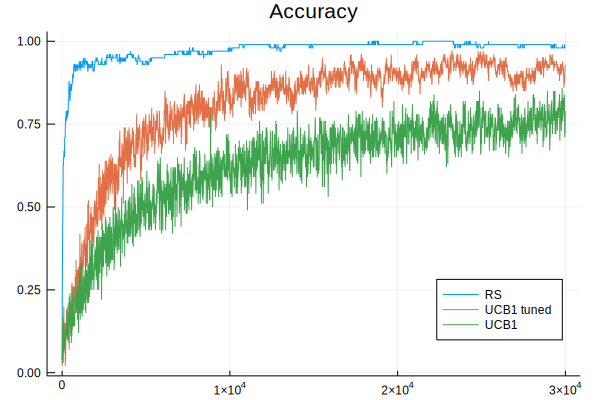

In [8]:
step_axis = [i for i=1:10:size(g1)[1]]
graph = [g1[i, :] for i in step_axis]
graph = hcat(graph...)'
#plot(1:size(g1)[1], g1, label=["RS","RS_tuned"], title="Accuracy")
plot(step_axis, graph, title="Accuracy", label=[key for key in keys(algo_dict)], legend=:bottomright)